In [1]:
#export
from exp.fully import *
import torch.nn.functional as F

# Initial setup

## Data

In [2]:
mpl.rcParams['image.cmap'] = 'gray'

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [5]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [6]:
model = Model(m, nh, 10)

In [7]:
pred = model(x_train)

## Cross-entropy loss

In [8]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [9]:
sm_pred = log_softmax(pred)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:
$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

In [10]:
y_train[:3]

tensor([5, 0, 4])

In [11]:
sm_pred.shape

torch.Size([50000, 10])

In [12]:
sm_pred[[0,1,2], [5,0,4]]  # grabs [0, 5], [1, 0], and [2, 4]

tensor([-2.2332, -2.4828, -2.3648], grad_fn=<IndexBackward>)

In [13]:
# look at all the rows (range(target.shape[0])), and the target column
def nll(preds, targets): return -preds[range(targets.shape[0]), targets].mean()

In [14]:
loss = nll(sm_pred, y_train)

In [15]:
loss

tensor(2.3242, grad_fn=<NegBackward>)

Note that the formula
$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [16]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [17]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:
$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [18]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us.

In [19]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [20]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [21]:
test_near(nll(log_softmax(pred), y_train), loss)

In [22]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [23]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop

In [24]:
loss_func = F.cross_entropy

In [25]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1) == yb).float().mean()

In [26]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.1363, -0.0361, -0.0413,  0.1365, -0.0021,  0.0589, -0.0448, -0.0527,
         -0.0463,  0.0341], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [27]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3230, grad_fn=<NllLossBackward>)

In [28]:
accuracy(preds, yb)

tensor(0.0938)

In [29]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [30]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        loss = loss_func(model(xb), yb)
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [31]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0907, grad_fn=<NllLossBackward>), tensor(0.9375))

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

In [32]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [33]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [34]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [35]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [36]:
model = Model(m, nh, 10)

In [37]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


PyTorch also overrides `__repr__`:

In [38]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [39]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [40]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1245, grad_fn=<NllLossBackward>), tensor(0.9375))

### Modules

We can use the original layers approach, but we have to register the modules.

In [41]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [42]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        # Like our self._modules = ...
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [43]:
model = Model(layers)

In [44]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

`nn.ModuleList` does this for us.

In [45]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [46]:
model = SequentialModel(layers)

In [47]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [48]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0887, grad_fn=<NllLossBackward>), tensor(1.))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [49]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [50]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0546, grad_fn=<NllLossBackward>), tensor(1.))

### optim

In [51]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [52]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [53]:
opt = Optimizer(model.parameters())

In [54]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [55]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0550, grad_fn=<NllLossBackward>), tensor(1.))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [56]:
#export
from torch import optim

In [57]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [58]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.3277, grad_fn=<NllLossBackward>)

In [59]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [60]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.1234, grad_fn=<NllLossBackward>), tensor(0.9375))

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]

Instead, let's do these two steps together, by introducing a Dataset class:

    xb,yb = train_ds[i*bs : i*bs+bs]

In [62]:
#export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [63]:
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [64]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)

In [65]:
model, opt = get_model()

In [66]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [67]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0788, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```{py}
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```{py}
for xb,yb in train_dl:
    ...
```

In [68]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [69]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [70]:
xb,yb = next(iter(valid_dl))
assert xb.shape == (bs,28*28)
assert yb.shape == (bs,)

tensor(3)

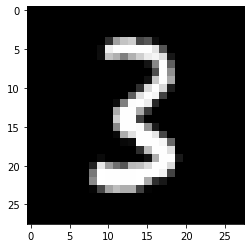

In [71]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [72]:
model,opt = get_model()

In [73]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [74]:
fit()

In [75]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0999, grad_fn=<NllLossBackward>), tensor(0.9688))

### Random sampling

In [76]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [77]:
small_ds = Dataset(*train_ds[:10])

In [78]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [79]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([6, 9, 7]), tensor([8, 3, 2]), tensor([5, 0, 4]), tensor([1])]

In [80]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [81]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [82]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

In [83]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0860, grad_fn=<NllLossBackward>), tensor(0.9844))

### PyTorch DataLoader

In [84]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [85]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [86]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0614, grad_fn=<NllLossBackward>), tensor(0.9844))

Or you can use PyTorch's defaults:

In [87]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [88]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.2054, grad_fn=<NllLossBackward>), tensor(0.9375))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your Dataset.

## Validation

You always should also have a validation set, in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [89]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        print(model.training)
        
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        print(model.training)
        
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
                
        nv = len(valid_dl)
        print(epoch, tot_loss / nv, tot_acc / nv)
        
    return tot_loss/nv, tot_acc/nv

`get_dls` returns dataloaders for the training and validation sets:

In [90]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [91]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

True
False
0 tensor(0.1695) tensor(0.9513)
True
False
1 tensor(0.1449) tensor(0.9565)
True
False
2 tensor(0.1630) tensor(0.9511)
True
False
3 tensor(0.1007) tensor(0.9723)
True
False
4 tensor(0.1026) tensor(0.9719)


# Export

In [93]:
!python3 notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to minibatch.py
